# **Predicting Cardio Disease**

# **Importing Required Libraries**

In [1]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# **Feature Selection Using Sequential Floating Backward Search**

In [3]:
#Selecting features using Sequential Floating Backward Search
def sfbs_calc(X, y, model):

  #SFBS using KNN as classifier
  #knn = KNeighborsClassifier(n_neighbors=3) 
  sfbs = SFS(model, 
            k_features=6,  #to select number of features
            forward=False, #to select forward/backward
            floating=True, #to set if floating required or not
            scoring='accuracy',
            cv=10, #10 fold cross validation
            n_jobs=-1
            )

  #after applying sfbs fit the data:
  features = ['age_year', 'gender', 'height', 'weight', 'ap_hi',
        'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

  sfbs.fit(X, y, custom_feature_names=features)
  return sfbs

In [4]:
#reading the dataset
df = pd.read_csv("data.csv")
print(df.head())

print("\nDataframe summary")
print(df.info())

   id  age_days   age_year  gender  height  weight  ap_hi  ap_lo  cholesterol  \
0   0     18393  50.391781       2     168    62.0    110     80            1   
1   1     20228  55.419178       1     156    85.0    140     90            3   
2   2     18857  51.663014       1     165    64.0    130     70            3   
3   3     17623  48.282192       2     169    82.0    150    100            1   
4   4     17474  47.873973       1     156    56.0    100     60            1   

   gluc  smoke  alco  active  cardio  
0     1      0     0       1       0  
1     1      0     0       1       1  
2     1      0     0       0       1  
3     1      0     0       1       1  
4     1      0     0       0       0  

Dataframe summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age_days     70000 n

**Checking for Missing data and Class Imbalance**

In [5]:
# checking count of instances in each class
print("\nChecking count of instances in each class")
print(df['cardio'].value_counts())

# checking for missing values
print("\nChecking for null values")
print(df.isna().sum())


Checking count of instances in each class
0    35021
1    34979
Name: cardio, dtype: int64

Checking for null values
id             0
age_days       0
age_year       0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


**Checking for Co-relation between features**

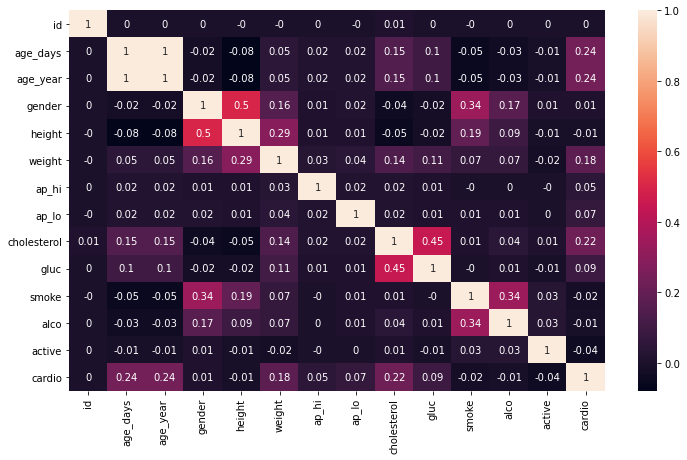

In [6]:
# checking correlation between features
corrMatrix = round(df.corr(),2)
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corrMatrix, annot=True, ax=ax)
plt.show()

In [7]:
#removing ID column and age_days column - age_days and age_years have correlation value of 1
df = df.iloc[:, 2:]
print("\nRemoved ID column and age_days column - age_days and age_years have correlation value of 1")
print(df.head())

X = df.iloc[:, :-1]
y = df['cardio']


Removed ID column and age_days column - age_days and age_years have correlation value of 1
    age_year  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  50.391781       2     168    62.0    110     80            1     1      0   
1  55.419178       1     156    85.0    140     90            3     1      0   
2  51.663014       1     165    64.0    130     70            3     1      0   
3  48.282192       2     169    82.0    150    100            1     1      0   
4  47.873973       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


# **Defining the six Classifier Models**

In [13]:
# keeping all the models inside a dictionary so that the accuracies can be recorded against each model in the dictionary

models = {}
model_params = {}


models['NB_Gaussian'] = GaussianNB()
model_params['NB_Gaussian'] = {}


models['Decision_Tree'] = DecisionTreeClassifier()
model_params['Decision_Tree'] = {'criterion':['gini', 'entropy']}

models['SGD'] = SGDClassifier(loss='hinge')
model_params['SGD'] = {}


#For one iteration KNN ran for 15 minutes and took 1 hour 15 minutes for 5 fold CV
models['Logistic_Regression'] = LogisticRegression(max_iter=130)
model_params['Logistic_Regression'] = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],'max_iter':range(80,140)}

#For one iteration KNN ran for 20 minutes and took 2 hours for 5 fold CV
models['KNN'] = KNeighborsClassifier(weights = 'distance')
model_params['KNN'] = {'n_neighbors':range(3,8)}

#For one iteration RF ran for 1 hour and took 5 hours for 5 fold CV
models['RF'] = RandomForestClassifier(random_state = 0)
model_params['RF'] = {'n_estimators':range (90,210,20)}


# list of n_folds for cross validation. 
n_fold = 5

**Stratified K fold Cross Validation** 

Feature Scaling and Feature Selection done for training set in every iteration

Hyper parameter tuning done using Grid Search

In [9]:

#print("\nCheck point 1....")
print("\n Stratified KFold with {} folds".format(n_fold))

# create n stratified folds for CV
s_kfold = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = 1)

# dictionary to keep track of accuracy of all the models in each iteration of kfolds
# sample for 3fold CV: model_accuracies = {'Logistic_Regression':[0.7,0.8,0.7], 'KNN':[0.8,0.9,0.8]}
model_accuracies = {}
model_metrics = {}

# dictionary to keep track of parameters for plotting roc_auc of all the models from each iteration of kfolds
# sample for 3fold CV: model_auc_roc = {'Logistic_Regression':[(fpr,tpr,auc), (fpr,tpr,auc),..], 'KNN':[(fpr,tpr,auc),(fpr,tpr,auc),.]}
# fpr --> false positive rates, tpr --> true positive rates, auc --> auc score
model_auc_roc = {}

model_features = {}

# flag variable to initialize list variable for each model in the above dictionary to record model_accuracy and model_auc
# this variable is set to False inside the first iteration of kfold CV
initialization = True
curr_iter = 1

# tqdm is just for visualizing the progress
# parameter y is enough to split the indices in kfold stratified CV, np.zeros(len(y)) is just placeholder for X
# split() returns the training instance indices and testing instance indices corresponding to the nfolds
for train_index, test_index in tqdm(s_kfold.split(np.zeros(len(y)), y), total=s_kfold.get_n_splits()):
  print("\nIteration {}".format(curr_iter))
  iter_start_time = time.time()
  #print("Start time: {}".format(iter_start_time))

  #print("\ncheck point 2....")
  # separating X and y for training and testing
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # scaling training and testing dataset separately
  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # initializing lists of models_accuracies and model_auc_roc
  if initialization:
    for model in models:
      model_accuracies[model] = []
      model_auc_roc[model] = []
      model_features[model] = []
      model_metrics[model] = []
    initialization = False

  # each iteration of k-fold stratified CV applied for all the models
  for model in models:
    print("Running model: {}".format(model))
    model_start_time = time.time()
    #print("Start time: {}".format(model_start_time))
    #print("\ncheck point 3....")        

    # selecting features with the training dataset
    print("Finding Feature subset....")
    features_subset = sfbs_calc(X_train, y_train, models[model])

    fs_current = list(features_subset.k_feature_names_)
    '''print("Model: {}".format(model))
    print("Current Features: {}".format(fs_current))
    print("Overall features without current features: {}".format(model_features[model]))'''

    # to store the features selected at each iteration
    additional_diff = np.setdiff1d(fs_current, model_features[model])
    model_features[model].extend(additional_diff)

    #print("Overall features with current features: {}".format(model_features[model]))

    # transforming the training dataset with the features selected from above step
    X_train_subset = features_subset.transform(X_train)

    # transforming the testing dataset with the features selected from above step
    X_test_subset = features_subset.transform(X_test)

    # finding best hyperparameters for
    print("Tuning hyperparameters....")
    grid_search = GridSearchCV(models[model],model_params[model], cv=10, scoring='accuracy')
    grid_search.fit(X_train_subset, y_train)
    #print(grid_search.best_estimator_)
    current_model = grid_search.best_estimator_

    print("Training model....")
    current_model.fit(X_train_subset, y_train)

    # since SGD with hinge loss does not have probability estimates, calibrating using below for probability estimates
    if model=='SGD':
        # cv=prefit tells calibrator that the current_model is already fit with training data
        # calibrated model is again taken as current_model and proceeded further
        calibrated_classfier = CalibratedClassifierCV(current_model, cv='prefit')
        current_model = calibrated_classfier.fit(X_train_subset, y_train)

    # accuracy score of a model is calculated using the training dataset and 
    # it is appended to dictionary for corresponding iteration of kfold
    print("Evaluating model....")
    #model_accuracies[model].append(current_model.score(X_test_subset, y_test))
    pred_y = current_model.predict(X_test_subset)

    model_accuracies[model].append(accuracy_score(y_test, pred_y))
    model_metrics[model].append(precision_recall_fscore_support(y_test, pred_y, average = 'binary'))


    # roc_auc works on probabilities, hence predicting probabilities using predict_proba() with testing dataset
    proba_ = current_model.predict_proba(X_test_subset)

    # keeping only the positive classes from the probabilities (proba_[:, 1]) and
    # calculated false positive rates and true positive rates
    fpr, tpr, _ = roc_curve(y_test, proba_[:, 1])
    roc_auc = auc(fpr, tpr)

    # fpr, tpr and auc score is recorded for this model for this particular iteration of kfolds
    model_auc_roc[model].append((fpr, tpr, roc_auc))
    model_end_time = time.time() - model_start_time
    print("Model total time: {}".format(model_end_time))

  iter_end_time = time.time() - iter_start_time
  print("Iteration {} total time: {}".format(curr_iter, iter_end_time))
  curr_iter += 1


print("\nThe below features are selected by the models atleast once during the feature selection phase in {} fold CV"
   .format(n_fold))
for model in model_features:
    print("\nModel: {}".format(model))
    print("Features: {}".format(model_features[model]))


 Stratified KFold with 5 folds



Iteration 1
Running model: NB_Gaussian
Finding Feature subset....
Tuning hyperparameters....
Training model....
Evaluating model....
Model total time: 22.49995517730713
Running model: SGD
Finding Feature subset....
Tuning hyperparameters....
Training model....
Evaluating model....
Model total time: 61.781203508377075
Iteration 1 total time: 84.35097241401672

Iteration 2
Running model: NB_Gaussian
Finding Feature subset....
Tuning hyperparameters....
Training model....
Evaluating model....
Model total time: 12.650198698043823
Running model: SGD
Finding Feature subset....
Tuning hyperparameters....
Training model....
Evaluating model....
Model total time: 56.585790395736694
Iteration 2 total time: 69.28038334846497

Iteration 3
Running model: NB_Gaussian
Finding Feature subset....
Tuning hyperparameters....
Training model....
Evaluating model....
Model total time: 12.13822317123413
Running model: SGD
Finding Feature subset....
Tuning hyperparameters....
Training model....
Evaluating mo

**Display performance metrices for all the models**

In [10]:
for model in model_metrics:
    precision = 0
    recall = 0
    fscore = 0
    for iter_each in model_metrics[model]:
        #print(iter_each)
        precision += iter_each[0]
        recall += iter_each[1]
        fscore += iter_each[2]
    precision = precision / n_fold
    recall = recall / n_fold
    fscore = fscore / n_fold
    print("\nModel: {}".format(model))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("FScore: {}".format(fscore))
    print("Accuracy: {}".format(np.mean(model_accuracies[model])))


Model: NB_Gaussian
Precision: 0.6776625926054638
Recall: 0.4830040325299742
FScore: 0.5639938397889981
Accuracy: 0.626842857142857

Model: SGD
Precision: 0.6476525244920015
Recall: 0.6190567917703202
FScore: 0.6330000197068286
Accuracy: 0.6413285714285715


**AUC-ROC Graph**

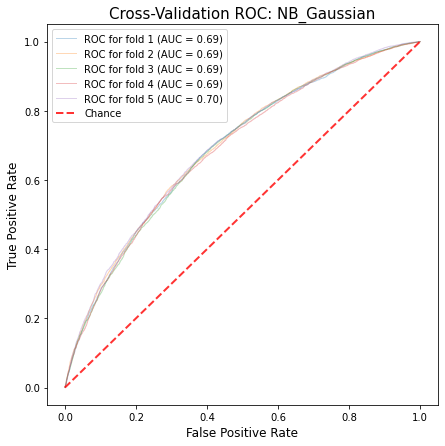

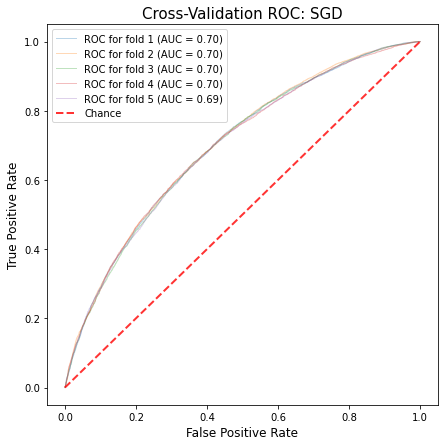

In [11]:
# plotting graph for all models with the roc_auc parameters from model_auc_roc dictionary
for model in model_auc_roc:
  plt.figure(figsize=(7,7))
  for i, score in enumerate(model_auc_roc[model]):
    fpr = score[0]
    tpr = score[1]
    roc_auc = score[2]
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC for fold %d (AUC = %0.2f)' % (i+1, roc_auc))

  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)
  plt.xlabel('False Positive Rate',fontsize=12)
  plt.ylabel('True Positive Rate',fontsize=12)
  plt.title('Cross-Validation ROC: '+model,fontsize=15)
  plt.legend()
  plt.show()
  print("\n")

**Plotting Bar Chart for accuracy comparison between models**

Text(0, 0.5, 'Accuracy in percentage')

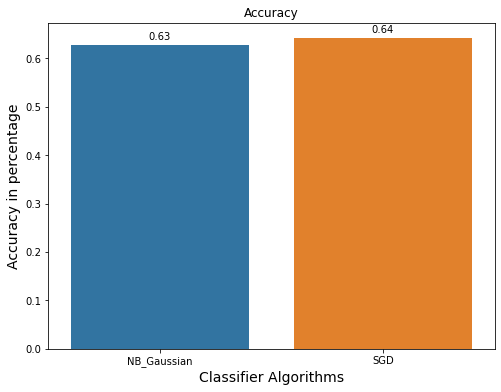

In [12]:
x = []
y = []

for model in models:
    x.append(model)
    y.append(np.mean(model_accuracies[model]))
    

df = pd.DataFrame({"X":x, "Y":y})

plt.figure(figsize=(8, 6))
splot=sns.barplot(x="X",y="Y",data=df)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.title("Accuracy")
plt.xlabel("Classifier Algorithms",size=14)
plt.ylabel("Accuracy in percentage",size=14)